In [1]:
#EDA
import pandas as pd
import pingouin as pg
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
# machine learn
from sklearn.model_selection import cross_validate, StratifiedKFold, cross_val_predict, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# otimização de hiperparametros
import optuna


/tmp/ipykernel_391778/3167927888.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df_segmento = pd.read_csv('./data.csv')

In [3]:
df_segmento.head(10)

,atividade_economica,faturamento_mensal,numero_de_funcionarios,localizacao,idade,inovacao,segmento_de_cliente
0,Comércio,713109.95,12,Rio de Janeiro,6,1,Bronze
1,Comércio,790714.38,9,São Paulo,15,0,Bronze
2,Comércio,1197239.33,17,São Paulo,4,9,Silver
3,Indústria,449185.78,15,São Paulo,6,0,Starter
4,Agronegócio,1006373.16,15,São Paulo,15,8,Silver
5,Serviços,1629562.41,16,Rio de Janeiro,11,4,Silver
6,Serviços,771179.95,13,Vitória,0,1,Starter
7,Serviços,707837.61,16,São Paulo,10,6,Silver
8,Comércio,888983.66,17,Belo Horizonte,10,1,Bronze
9,Indústria,1098512.64,13,Rio de Janeiro,9,3,Bronze


In [4]:
df_segmento['atividade_economica'].unique()

array(['Comércio', 'Indústria', 'Agronegócio', 'Serviços'], dtype=object)

In [5]:
df_segmento['localizacao'].unique()

array(['Rio de Janeiro', 'São Paulo', 'Vitória', 'Belo Horizonte'],
      dtype=object)

In [6]:
df_segmento['segmento_de_cliente'].unique()

array(['Bronze', 'Silver', 'Starter', 'Gold'], dtype=object)

In [7]:
df_segmento['inovacao'].unique()

array([1, 0, 9, 8, 4, 6, 3, 7, 5, 2])

In [8]:
# Distribuição da variavel segmento de cliente (Target)
constagem_target = df_segmento.value_counts('segmento_de_cliente')
constagem_target


segmento_de_cliente
Silver     260
Bronze     202
Starter     22
Gold        16
Name: count, dtype: int64

In [9]:
# criar lista ordenada target
lista_segmentos = ['Starter', 'Bronze', 'Silver', 'Gold']

In [10]:
# distribuição da variavel target - contagem
px.bar(constagem_target, color=constagem_target.index, category_orders={'segmento_de_cliente': lista_segmentos})

/home/ubuntu/.local/share/virtualenvs/clasificassao_arvore_decisao-WmOUc7tw/lib/python3.11/site-packages/plotly/express/_core.py:2065: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sf: grouped.get_group(s if len(s) > 1 else s[0])


In [11]:
# distribuição variavel localização
percentual_localizacao = df_segmento.value_counts('localizacao') / len(df_segmento) * 100
px.bar(percentual_localizacao, color=percentual_localizacao.index)

/home/ubuntu/.local/share/virtualenvs/clasificassao_arvore_decisao-WmOUc7tw/lib/python3.11/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [12]:
# distribuição variavel atividade economica
percentual_atividade = df_segmento.value_counts('atividade_economica') / len(df_segmento) * 100
px.bar(percentual_atividade, color=percentual_atividade.index)

/home/ubuntu/.local/share/virtualenvs/clasificassao_arvore_decisao-WmOUc7tw/lib/python3.11/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [13]:
# distribuição variavel atividade inovacao
percentual_inovacao = df_segmento.value_counts('inovacao') / len(df_segmento) * 100
px.bar(percentual_inovacao, color=percentual_inovacao.index)

In [14]:
# tabela de contingência entre localização e target
crosstab_locaiizacao = pd.crosstab(df_segmento['localizacao'], df_segmento['segmento_de_cliente'],
margins=True)[lista_segmentos].reset_index()
tabela_localizacao = ff.create_table(crosstab_locaiizacao)
tabela_localizacao.show()

In [15]:
# tabela de contingência entre localização e target
crosstab_atividade = pd.crosstab(df_segmento['atividade_economica'], df_segmento['segmento_de_cliente'],
margins=True)[lista_segmentos].reset_index()
tabela_atividade = ff.create_table(crosstab_atividade)
tabela_atividade.show()

In [16]:
# tabela de contingência entre localização e inovacao
crosstab_inovacao = pd.crosstab(df_segmento['inovacao'], df_segmento['segmento_de_cliente'],
margins=True)[lista_segmentos].reset_index()
tabela_inovacao = ff.create_table(crosstab_inovacao)
tabela_inovacao.show()

In [17]:
# distribuicao idade da empresa
px.histogram(df_segmento, x='idade')

In [18]:
# distribuicao faturamento mensal
px.histogram(df_segmento, x='faturamento_mensal')

In [19]:
# idade e segmento
px.box(df_segmento, x='segmento_de_cliente', y='idade', color='segmento_de_cliente',
category_orders={'segmento_de_cliente': lista_segmentos})

/home/ubuntu/.local/share/virtualenvs/clasificassao_arvore_decisao-WmOUc7tw/lib/python3.11/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [20]:
# faturamento e segmento
px.box(df_segmento, x='segmento_de_cliente', y='faturamento_mensal', color='segmento_de_cliente',
category_orders={'segmento_de_cliente': lista_segmentos})

/home/ubuntu/.local/share/virtualenvs/clasificassao_arvore_decisao-WmOUc7tw/lib/python3.11/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [21]:
# teste de quiquadradi de person
#h0 as variaveis sao dependente
#h1 as variaveis nao sao dependente
valor_esperado, valor_observado, estatisticas   = pg.chi2_independence(df_segmento, 'segmento_de_cliente', 'inovacao')

/home/ubuntu/.local/share/virtualenvs/clasificassao_arvore_decisao-WmOUc7tw/lib/python3.11/site-packages/pingouin/contingency.py:151: UserWarning:

Low count on observed frequencies.

/home/ubuntu/.local/share/virtualenvs/clasificassao_arvore_decisao-WmOUc7tw/lib/python3.11/site-packages/pingouin/contingency.py:151: UserWarning:

Low count on expected frequencies.

/home/ubuntu/.local/share/virtualenvs/clasificassao_arvore_decisao-WmOUc7tw/lib/python3.11/site-packages/scipy/stats/_stats_py.py:8031: RuntimeWarning:

divide by zero encountered in power

/home/ubuntu/.local/share/virtualenvs/clasificassao_arvore_decisao-WmOUc7tw/lib/python3.11/site-packages/scipy/stats/_stats_py.py:8031: RuntimeWarning:

invalid value encountered in multiply

/home/ubuntu/.local/share/virtualenvs/clasificassao_arvore_decisao-WmOUc7tw/lib/python3.11/site-packages/scipy/stats/_stats_py.py:8028: RuntimeWarning:

divide by zero encountered in divide



In [22]:
# valor esperado 
# é a frequencia se nao houvese associcao entre as variaveis 
# é calculado utilizando a distrubuição assumida no teste qui-dradrado
valor_esperado

inovacao,0,1,2,3,4,5,6,7,8,9
segmento_de_cliente,,,,,,,,,,
Bronze,21.008,23.028,22.624,19.392,17.372,17.372,21.816,21.412,18.988,18.988
Gold,1.664,1.824,1.792,1.536,1.376,1.376,1.728,1.696,1.504,1.504
Silver,27.040,29.640,29.120,24.960,22.360,22.360,28.080,27.560,24.440,24.440
Starter,2.288,2.508,2.464,2.112,1.892,1.892,2.376,2.332,2.068,2.068


In [23]:
# valor observado 
# é a frequencial real
valor_observado

inovacao,0,1,2,3,4,5,6,7,8,9
segmento_de_cliente,,,,,,,,,,
Bronze,36,44,32,22,12,14,15,12,9,6
Gold,0,0,0,0,0,3,0,5,4,4
Silver,10,5,20,25,30,25,38,36,34,37
Starter,6,8,4,1,1,1,1,0,0,0


In [24]:
# estaticas 
estatisticas.round(5)

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.00000,164.29399,27.0,0.0,0.33095,0.99850
1,cressie-read,0.66667,165.49946,27.0,0.0,0.33216,0.99861
2,log-likelihood,0.00000,181.48878,27.0,0.0,0.34784,0.99951
3,freeman-tukey,-0.50000,NaN,27.0,NaN,NaN,NaN
4,mod-log-likelihood,-1.00000,inf,27.0,0.0,inf,NaN
5,neyman,-2.00000,NaN,27.0,NaN,NaN,NaN


In [25]:
## treinamento modeilo
# separar X e y
X = df_segmento.drop(columns=['segmento_de_cliente'])
y = df_segmento['segmento_de_cliente']

In [26]:
# Pipeline
# OneHotEncode nas variaveis categóricas 
# treinamento de modelo

#lista de váriaveis categóricas
categorical_features = ['atividade_economica', 'localizacao']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ]
)
# Pipeline com opre-processor e o modelo de arqvore de decisao
dt_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier())
])

In [27]:
# validação cruzada
# treinar modelo com validação cruzada, usando stratifiedKFold, dado que as classes estão desbalanceadas
cv_folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=51)
metrics_result = cross_validate(dt_model, X, y, cv=cv_folds, scoring=['accuracy'], return_estimator=True)

In [28]:
metrics_result

{'fit_time': array([0.01463842, 0.00597668, 0.00698876]),
 'score_time': array([0.00502706, 0.00277448, 0.0028255 ]),
 'estimator': [Pipeline(steps=[('preprocessor',
                   ColumnTransformer(transformers=[('cat',
                                                    Pipeline(steps=[('imputer',
                                                                     SimpleImputer(strategy='most_frequent')),
                                                                    ('onehot',
                                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                                    ['atividade_economica',
                                                     'localizacao'])])),
                  ('classifier', DecisionTreeClassifier())]),
  Pipeline(steps=[('preprocessor',
                   ColumnTransformer(transformers=[('cat',
                                                    Pipeline(steps=[('imputer',
        

In [29]:
# média de acurácia, considerandoo os 3 splits
metrics_result['test_accuracy'].mean()

0.4739917754851743

In [30]:
# acuracia 
# total previsoes corretas / total de previsoes
y_pred = cross_val_predict(dt_model, X, y, cv=cv_folds)


In [31]:
classification_report_str = classification_report(y, y_pred)
print(f'Relatório de classifição\n{classification_report_str}')

Relatório de classifição
              precision    recall  f1-score   support

      Bronze       0.41      0.36      0.38       202
        Gold       0.00      0.00      0.00        16
      Silver       0.51      0.63      0.57       260
     Starter       0.00      0.00      0.00        22

    accuracy                           0.47       500
   macro avg       0.23      0.25      0.24       500
weighted avg       0.43      0.47      0.45       500



/home/ubuntu/.local/share/virtualenvs/clasificassao_arvore_decisao-WmOUc7tw/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/ubuntu/.local/share/virtualenvs/clasificassao_arvore_decisao-WmOUc7tw/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/ubuntu/.local/share/virtualenvs/clasificassao_arvore_decisao-WmOUc7tw/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



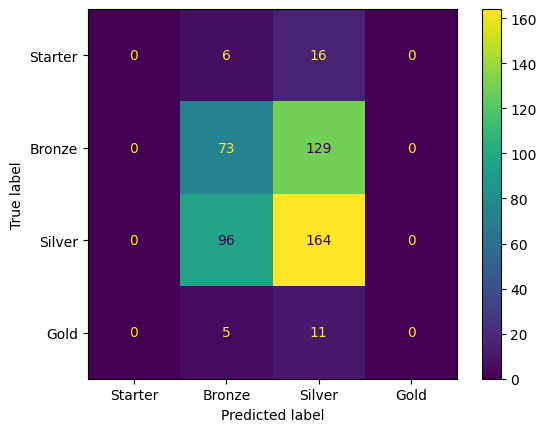

In [32]:
# mostrar matriz de confusão
confusion_matrix_modelo = confusion_matrix(y, y_pred, labels=lista_segmentos)
disp = ConfusionMatrixDisplay(confusion_matrix_modelo, display_labels=lista_segmentos)
disp.plot()

In [33]:
def decisiontree_optuna(trial): 
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_depth = trial.suggest_int('max_depth', 2, 8)
    dt_model.set_params(classifier__min_samples_leaf=min_samples_leaf)
    dt_model.set_params(classifier__max_depth=max_depth)
    scores = cross_val_score(dt_model, X, y, cv=cv_folds, scoring='accuracy')
    return scores.mean()

In [34]:
estudo_decissiont_tree = optuna.create_study(direction='maximize')
estudo_decissiont_tree.optimize(decisiontree_optuna, n_trials=100)

[I 2024-02-13 12:31:31,775] A new study created in memory with name: no-name-fc213d0d-4b33-42a4-9151-a47c0be1e5a8
[I 2024-02-13 12:31:31,817] Trial 0 finished with value: 0.4620037034365005 and parameters: {'min_samples_leaf': 19, 'max_depth': 2}. Best is trial 0 with value: 0.4620037034365005.
[I 2024-02-13 12:31:31,861] Trial 1 finished with value: 0.4739917754851743 and parameters: {'min_samples_leaf': 10, 'max_depth': 7}. Best is trial 1 with value: 0.4739917754851743.


[I 2024-02-13 12:31:31,900] Trial 2 finished with value: 0.46997571122814613 and parameters: {'min_samples_leaf': 17, 'max_depth': 7}. Best is trial 1 with value: 0.4739917754851743.
[I 2024-02-13 12:31:31,934] Trial 3 finished with value: 0.4739917754851743 and parameters: {'min_samples_leaf': 3, 'max_depth': 6}. Best is trial 1 with value: 0.4739917754851743.
[I 2024-02-13 12:31:31,970] Trial 4 finished with value: 0.4739917754851743 and parameters: {'min_samples_leaf': 4, 'max_depth': 8}. Best is trial 1 with value: 0.4739917754851743.
[I 2024-02-13 12:31:32,001] Trial 5 finished with value: 0.45398359906692637 and parameters: {'min_samples_leaf': 11, 'max_depth': 5}. Best is trial 1 with value: 0.4739917754851743.
[I 2024-02-13 12:31:32,031] Trial 6 finished with value: 0.45398359906692637 and parameters: {'min_samples_leaf': 12, 'max_depth': 5}. Best is trial 1 with value: 0.4739917754851743.
[I 2024-02-13 12:31:32,064] Trial 7 finished with value: 0.45398359906692637 and paramete

In [44]:
print(f'melhor acurácia: {estudo_decissiont_tree.best_value}')
print(f'melhor parametros: {estudo_decissiont_tree.best_params}')

melhor acurácia: 0.4740518962075848
melhor parametros: {'min_samples_leaf': 12, 'max_depth': 2}


In [37]:
# preparar o conjunto de dados para treinar e conseguir visualizar a árvore
X_train_tree = X.copy()
X_train_tree['localizacao_label'] = X_train_tree.localizacao.astype('category').cat.codes
X_train_tree['atividade_economica_label'] = X_train_tree.atividade_economica.astype('category').cat.codes
X_train_tree.drop(columns=['localizacao', 'atividade_economica'], axis=1, inplace=True)
X_train_tree.rename(columns={'localizacao_label':'localizacao', 'atividade_economica_label': 'atividade_economica'}, inplace=True)
X_train_tree.head(10)


,faturamento_mensal,numero_de_funcionarios,idade,inovacao,localizacao,atividade_economica
0,713109.95,12,6,1,1,1
1,790714.38,9,15,0,2,1
2,1197239.33,17,4,9,2,1
3,449185.78,15,6,0,2,2
4,1006373.16,15,15,8,2,0
5,1629562.41,16,11,4,1,3
6,771179.95,13,0,1,3,3
7,707837.61,16,10,6,2,3
8,888983.66,17,10,1,0,1
9,1098512.64,13,9,3,1,2


In [39]:
# treinar modelo com o conjunto de parametros ideal
clf_decisiontree = DecisionTreeClassifier(min_samples_leaf=estudo_decissiont_tree.best_params['min_samples_leaf'],
                                          max_depth=estudo_decissiont_tree.best_params['max_depth'])
y_train_tree = y.copy()
clf_decisiontree.fit(X_train_tree, y_train_tree)

DecisionTreeClassifier(max_depth=2, min_samples_leaf=7)

[Text(0.5, 0.8333333333333334, 'inovacao <= 2.5\ngini = 0.563\nsamples = 500\nvalue = [202, 16, 260, 22]\nclass = Silver'),
 Text(0.25, 0.5, 'faturamento_mensal <= 425959.422\ngini = 0.482\nsamples = 165\nvalue = [112, 0, 35, 18]\nclass = Starter'),
 Text(0.125, 0.16666666666666666, 'gini = 0.26\nsamples = 13\nvalue = [2, 0, 0, 11]\nclass = Gold'),
 Text(0.375, 0.16666666666666666, 'gini = 0.421\nsamples = 152\nvalue = [110, 0, 35, 7]\nclass = Starter'),
 Text(0.75, 0.5, 'faturamento_mensal <= 549601.438\ngini = 0.474\nsamples = 335\nvalue = [90.0, 16.0, 225.0, 4.0]\nclass = Silver'),
 Text(0.625, 0.16666666666666666, 'gini = 0.459\nsamples = 37\nvalue = [26, 0, 7, 4]\nclass = Starter'),
 Text(0.875, 0.16666666666666666, 'gini = 0.416\nsamples = 298\nvalue = [64.0, 16.0, 218.0, 0.0]\nclass = Silver')]

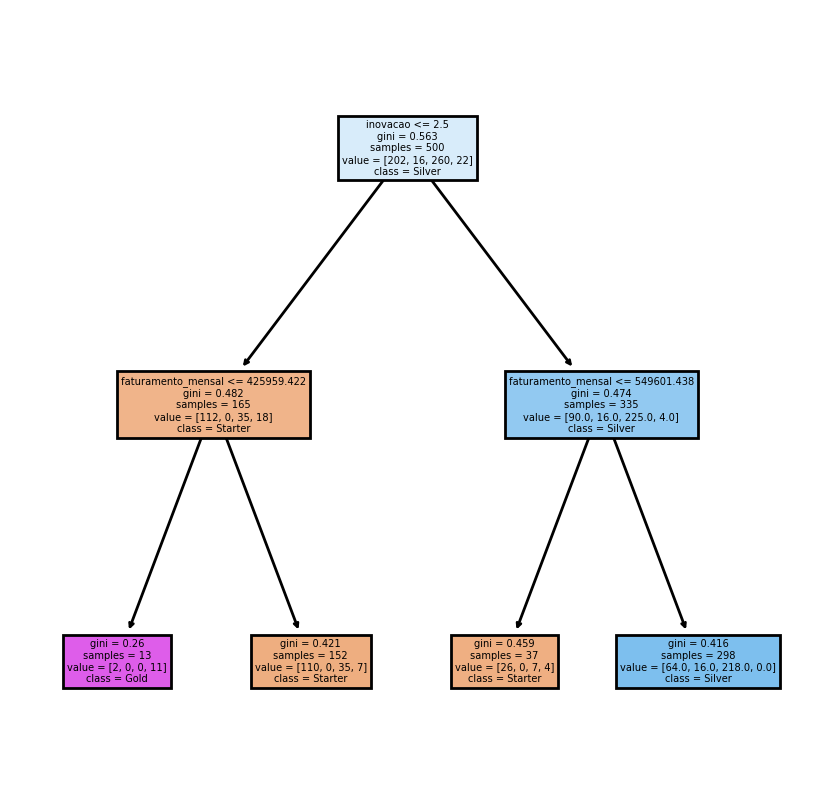

In [47]:
#visualizar arvore
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize=(5,5), dpi=200)
plot_tree(clf_decisiontree, 
          feature_names=X_train_tree.columns.to_numpy(),
          class_names=lista_segmentos,
          filled=True)

In [48]:
# salvar modelo
import joblib
# criar pipeline
dt_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier',  DecisionTreeClassifier(min_samples_leaf=estudo_decissiont_tree.best_params['min_samples_leaf'],
                                          max_depth=estudo_decissiont_tree.best_params['max_depth']))
])
dt_model.fit(X, y)
joblib.dump(dt_model, 'modelo_classificao.pkl')

['modelo_classificao.pkl']

In [49]:
import gradio as gr
modelo = joblib.load('./modelo_classificao.pkl')
def predict(arquivo):
    df_empresas =  pd.read_csv(arquivo.name)
    y_pred = modelo.predict(df_empresas)
    df_segmentos = pd.DataFrame(y_pred, columns=['segmento_de_clientes'])
    df_predicoes = pd.concat([df_empresas, df_segmentos], axis=1)
    df_predicoes.to_csv('./predicoes.csv', index=False)
    return './predicoes.csv'

demo = gr.Interface(
    predict,
    gr.File(file_types=['.csv']),
    'file'
)
demo.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
